In [1]:
%load_ext autoreload
%autoreload 2

In [8]:
from autoplan.generator import ProgramGenerator
from grammars.pythagorean.program import Program, PythagoreanLabels
from autoplan.dataset import build_synthetic_dataset
from autoplan.trainer import ParserTrainer, ClassifierTrainer
from autoplan.parsing import ProgramParser
from autoplan.token import JavaTokenizer
from tqdm import tqdm_notebook as tqdm
import torch
import pandas as pd
from pprint import pprint

device = torch.device('cpu')
#device = torch.device('cuda:0')

In [3]:
program_grammar = Program()
generator = ProgramGenerator(grammar=program_grammar)
program, choices, choice_options, labels = generator.generate()
print(program)
pprint(choices)
pprint(choice_options)
print(labels)


            public class PythagoreanTheorem extends ConsoleProgram {
                public void run() {
                    
        print("Enter values to compute the Pythagorean Theorem.");
        int x = readInt("Enter x:");
        int y = readInt("Enter y:");
        int z = Math.sqrt(x * x + y * y);
        print("The hypotenuse is" + z);
        
                }
            }
        
[('START', 0),
 ('naming_scheme', 1),
 ('num_type', 0),
 ('print_function', 1),
 ('main_prompt', 0),
 ('input_prompt', 1),
 ('uses_method', 1),
 ('output_prompt', 3)]
{'START': [(1.0, None)],
 'input_prompt': [(0.5555555820465088, ''),
                  (0.2222222238779068, 'Enter '),
                  (0.1111111119389534, 'enter value '),
                  (0.1111111119389534, 'Enter value for ')],
 'main_prompt': [(0.699999988079071,
                  'Enter values to compute the Pythagorean Theorem.'),
                 (0.15000000596046448,
                  'This program finds the hypotenu

In [37]:
dataset = build_synthetic_dataset(
    PythagoreanLabels,
    N_train=100, 
    N_val=10, 
    tokenizer=JavaTokenizer(),
    generator=ProgramGenerator(grammar=program_grammar))

# N_train = 1000 is when we reach 71-75% accuracy on parsing (maximum so far) and we don't get the accuracy decrease
# on loops 12.5-15.0. Bigger batches (N_train = 10000) seem to hurt accuracy

# N_train = 100, N_val = 10 is when we reach 80% accuracy on classifying (maximum so far)
# Bigger batches (N_train = 1000+) hurt accuracy

In [32]:
dataset.train_dataset[0]

{'program': tensor([ 0,  1,  2,  3,  4,  5,  0,  6,  7,  8,  9,  5, 10,  8, 11,  9, 12, 13,
         14, 15, 16,  8, 11,  9, 12, 13, 17, 15, 16,  8, 11,  9, 12, 13, 18, 15,
         19, 20, 21,  8, 14, 22, 14, 23, 17, 22, 17,  9, 12, 10,  8, 11, 23, 18,
          9, 12, 24, 24]),
 'trace': tensor([0, 1, 2, 3, 4, 5, 6, 7]),
 'choices': tensor([0, 0, 0, 0, 0, 0, 1, 1]),
 'labels': tensor(1)}

In [33]:
batch = next(iter(dataset.loader(dataset.val_dataset)))

In [34]:
trainer = ClassifierTrainer(program_grammar, dataset, device)
#trainer = NeuralParser(program_grammar, dataset, device)

In [35]:
losses = []
accuracy = []
for _ in tqdm(range(20)):
    losses.append(trainer.train_one_epoch())
    accuracy.append(trainer.eval())

[0.8, 0.8, 0.2, 0.2, 0.2, 0.2, 0.2, 0.8, 0.8, 0.8, 0.8, 0.8, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.8]


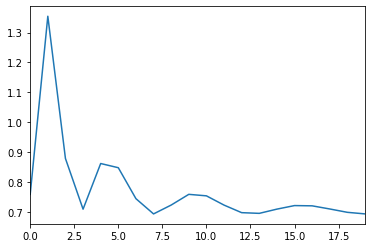

In [36]:
pd.Series(losses).plot()
print(accuracy)

In [ ]:
trainer.model.save('checkpoint.ph.tar')

In [ ]:
parser = ProgramParser(program_grammar, dataset, 'checkpoint.ph.tar', device)

In [ ]:
parser.infer(batch['program'][:1], batch['program_len'][:1])